# <center>Projet : Prévision Indice S&P</center>

Vous avez carte blanche pour définir le contour de votre outil mais ce dernier doit au moins
présenter les fonctionnalités suivantes :
<ul>
   
<li>Analyse exploratoire des données d'entrée (ici le SP500) avec une restitution graphique utilisant la librairie matplotlib.</li>
<li>Proposer au moins 3 modèles de calibration et de prévision, dont un réseau de neurones
utilisant la librairie tensorflow. Pour les deux autres modèles, vous utiliserez obligatoirement les librairies sklearn et numpy.</li>
<li>Intégrer le projet dans un contexte professionnel pour la restitution de votre travail</li> 
</ul>

In [1]:
import random

import pandas            as pd 
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
random.seed(42)

# Pour mac 
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

# Pour PC 
#import tensorflow        as tf

from scipy import stats


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

Instructions for updating:
non-resource variables are not supported in the long term


/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.

In [2]:
stock_df = pd.read_csv("data_stocks.csv", sep=";")

# Statistiques descriptives des variables explicatives

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


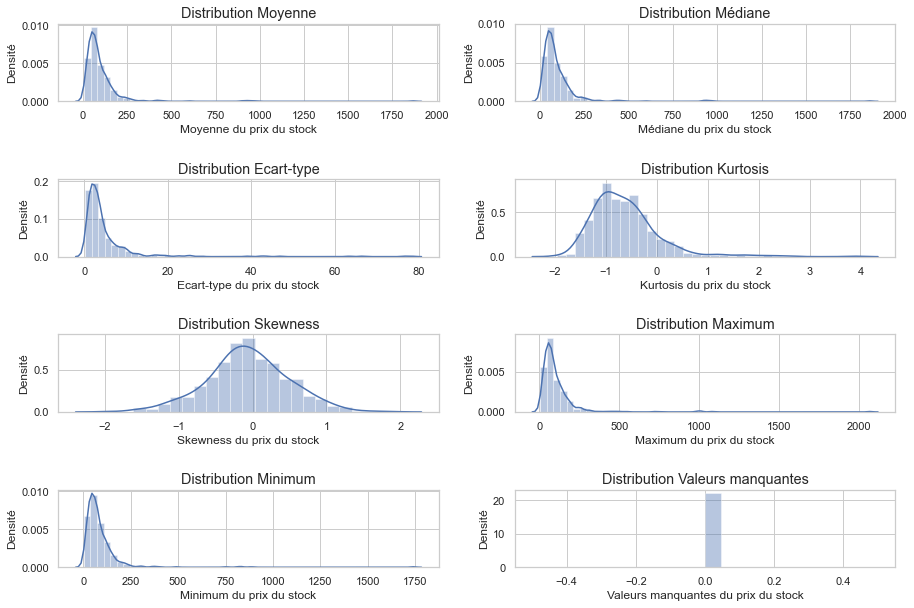

In [40]:
# Analyse descriptive

moy,med,ect,kut,skw,maxi,mini,val_manq={},{},{},{},{},{},{},{}

for i in stock_df.columns[2:]:
    moy[i]=np.mean(stock_df[i])
    med[i]=np.median(stock_df[i])
    ect[i]=stock_df[i].std()
    kut[i]=stats.kurtosis(stock_df[i])
    skw[i]=stats.skew(stock_df[i])
    maxi[i]=stock_df[i].max()
    mini[i]=stock_df[i].min()
    val_manq[i]=stock_df[i].isnull().sum()
    

liste=[moy,med,ect,kut,skw,maxi,mini,val_manq]
df_desc=pd.DataFrame(liste).transpose()
df_desc.columns=(['Moyenne','Médiane','Ecart-type','Kurtosis','Skewness','Maximum','Minimum','Valeurs manquantes'])

# plot
fig_1 = plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=1)
j=1
for i in df_desc.columns:
    ax_1 = fig_1.add_subplot(4,2,j)
    ax_1=sns.distplot(df_desc[i])
    plt.title("Distribution "+i,fontsize='large')
    ax_1.set(ylabel="Densité",xlabel=i+" du prix du stock")
    j+=1
plt.show()

In [66]:
df_desc.describe()

,Moyenne,Médiane,Ecart-type,Kurtosis,Skewness,Maximum,Minimum,Valeurs manquantes
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,97.778031,98.092433,5.011910,-0.628760,-0.062220,107.595430,87.675806,0.0
std,128.640700,129.333543,7.971931,0.676870,0.554514,142.527807,115.561199,0.0
min,4.990837,4.960000,0.262382,-1.956043,-1.942593,6.572500,3.550000,0.0
25%,44.632355,44.687500,1.725596,-1.070222,-0.396300,49.417500,39.427500,0.0
50%,70.695001,70.553125,3.073734,-0.736679,-0.072453,77.820000,63.922200,0.0
75%,113.925935,114.288750,5.166885,-0.350860,0.271745,123.872500,103.449375,0.0
max,1867.722306,1859.176650,78.341963,3.855879,1.832759,2067.500000,1738.462400,0.0


In [70]:
# Valeurs extrêmes de 'Ecart-type'
df_desc['Ecart-type'][df_desc['Ecart-type'].values >= 30]

NASDAQ.AMZN     38.966684
NASDAQ.GOOG     42.228052
NASDAQ.GOOGL    43.451194
NASDAQ.ISRG     66.399872
NASDAQ.PCLN     78.341963
NASDAQ.REGN     46.810038
NYSE.AZO        76.697768
NYSE.CMG        63.348471
Name: Ecart-type, dtype: float64

In [68]:
# Valeurs extrêmes de 'Ecart-type'
df_desc['Ecart-type'][df_desc['Ecart-type'].values <= 0.5]

NASDAQ.HBAN    0.358750
NASDAQ.PBCT    0.420250
NYSE.AES       0.281472
NYSE.F         0.262382
NYSE.HST       0.424612
NYSE.RF        0.378951
NYSE.WU        0.362162
Name: Ecart-type, dtype: float64

In [71]:
# Valeurs extrêmes de 'Moyenne'
df_desc['Moyenne'][df_desc['Moyenne'].values >= 450]

NASDAQ.AMZN      968.747188
NASDAQ.GOOG      922.131875
NASDAQ.GOOGL     941.369665
NASDAQ.ISRG      901.320301
NASDAQ.PCLN     1867.722306
NASDAQ.REGN      457.676948
NYSE.AZO         598.324633
Name: Moyenne, dtype: float64

In [65]:
# Valeurs extrêmes de 'Moyenne'
df_desc['Moyenne'][df_desc['Moyenne'].values <= 10]

NASDAQ.SPLS    9.666552
NYSE.CHK       4.990837
NYSE.RIG       9.564944
Name: Moyenne, dtype: float64

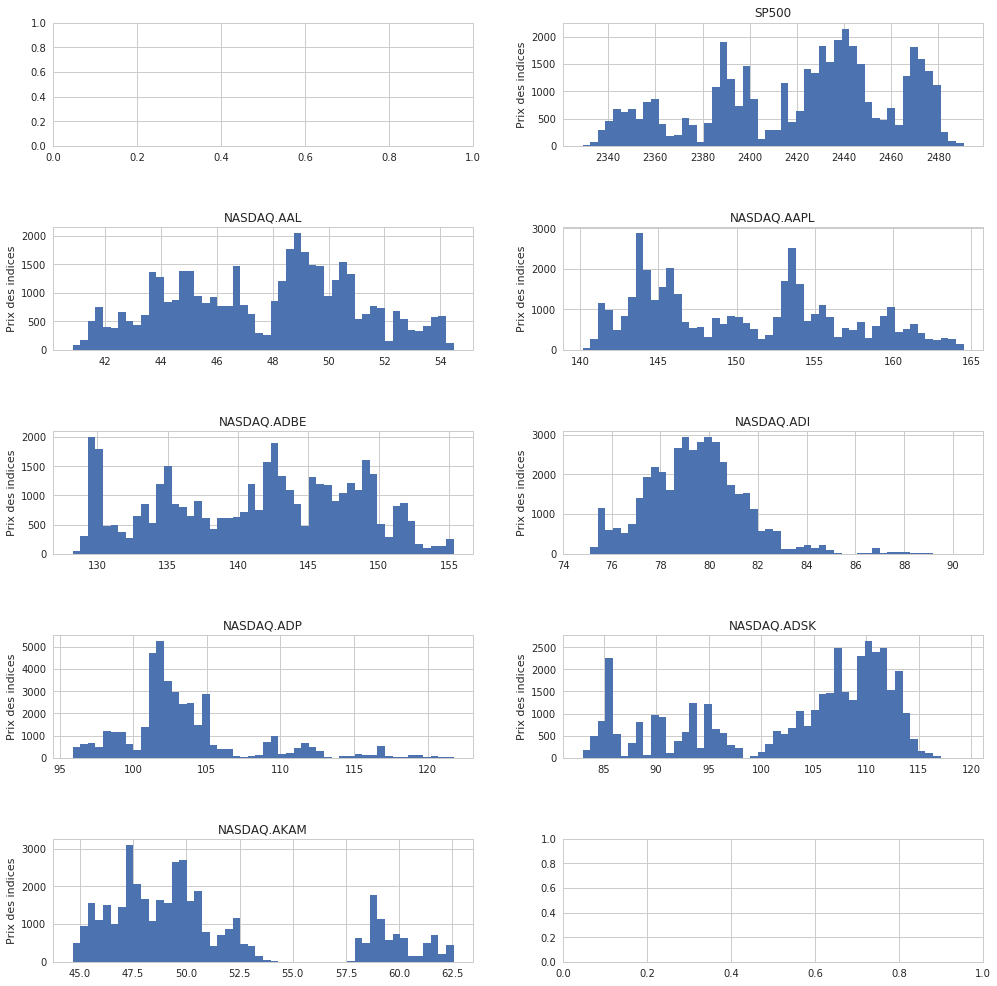

In [200]:
COLS       = [1,2,3,4,5,6,7,8]
fig, axs = plt.subplots(int(len(COLS)/2) + 1 , 2, figsize = (15,15))
fig.tight_layout(pad=5.0)



for idx in COLS:
    axs[idx // 2][idx % 2].hist(stock_df[stock_df.columns[idx]], bins=50)
    axs[idx // 2][idx % 2].set_ylabel("Prix des indices")
    axs[idx // 2][idx % 2].set_title(stock_df.columns[idx])
    
plt.show()



# Statistiques descriptives de la variable cible

In [81]:
df_plot = stock_df.copy()

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 <a list of 7 Text major ticklabel objects>)

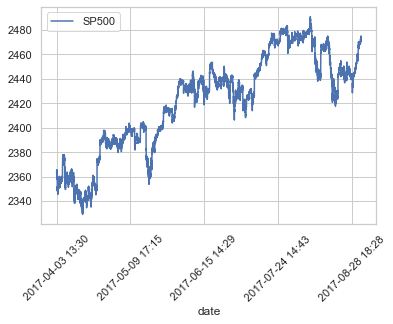

In [82]:
#Creation d'une colonne "date" avec le format normal
df_plot["date"]= [pd.to_datetime(day, unit='s').strftime('%Y-%m-%d %H:%M') for day in df_plot['DATE'].values]

#Plotting the data 
df_plot.iloc[0:41266].plot(x='date', y='SP500')
plt.xticks(rotation=45)

In [72]:
df_plot['SP500'].describe()

count    41266.000000
mean      2421.537882
std         39.557135
min       2329.139900
25%       2390.860100
50%       2430.149900
75%       2448.820100
max       2490.649900
Name: SP500, dtype: float64

# Préparation des données pour la modélisation

## Adaptation du dataset

L’objectif est de prédire la valeur du S&P 500 à l’instant t+1, en fonction du cours des actions des 500 entreprises incluses dans son calcul à l’instant t. Pour la modélisation, nous allons donc modifier le jeu de données pour faire correspondre Xt-1 à Yt. 

In [3]:
df_copy = stock_df.copy()

In [4]:
pd.set_option('display.max_columns',None)
df_decale = df_copy.iloc[:,[0,1]].join(df_copy.iloc[:,2:].shift())
df_decale.drop(labels=0,axis=0,inplace=True)
df_decale

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,NASDAQ.AMAT,NASDAQ.AMD,NASDAQ.AMGN,NASDAQ.AMZN,NASDAQ.ATVI,NASDAQ.AVGO,NASDAQ.BBBY,NASDAQ.BIIB,NASDAQ.CA,NASDAQ.CBOE,NASDAQ.CELG,NASDAQ.CERN,NASDAQ.CHRW,NASDAQ.CHTR,NASDAQ.CINF,NASDAQ.CMCSA,NASDAQ.CME,NASDAQ.COST,NASDAQ.CSCO,NASDAQ.CSX,NASDAQ.CTAS,NASDAQ.CTSH,NASDAQ.CTXS,NASDAQ.DISCA,NASDAQ.DISCK,NASDAQ.DISH,NASDAQ.DLTR,NASDAQ.EA,NASDAQ.EBAY,NASDAQ.EQIX,NASDAQ.ESRX,NASDAQ.ETFC,NASDAQ.EXPD,NASDAQ.EXPE,NASDAQ.FAST,NASDAQ.FB,NASDAQ.FFIV,NASDAQ.FISV,NASDAQ.FITB,NASDAQ.FLIR,NASDAQ.FOX,NASDAQ.FOXA,NASDAQ.GILD,NASDAQ.GOOG,NASDAQ.GOOGL,NASDAQ.GRMN,NASDAQ.GT,NASDAQ.HAS,NASDAQ.HBAN,NASDAQ.HOLX,NASDAQ.HSIC,NASDAQ.IDXX,NASDAQ.ILMN,NASDAQ.INCY,NASDAQ.INFO,NASDAQ.INTC,NASDAQ.INTU,NASDAQ.ISRG,NASDAQ.JBHT,NASDAQ.KHC,NASDAQ.KLAC,NASDAQ.LKQ,NASDAQ.LRCX,NASDAQ.MAR,NASDAQ.MAT,NASDAQ.MCHP,NASDAQ.MDLZ,NASDAQ.MNST,NASDAQ.MSFT,NASDAQ.MU,NASDAQ.MYL,NASDAQ.NAVI,NASDAQ.NDAQ,NASDAQ.NFLX,NASDAQ.NTAP,NASDAQ.NTRS,NASDAQ.NVDA,NASDAQ.NWS,NASDAQ.NWSA,NASDAQ.ORLY,NASDAQ.PAYX,NASDAQ.PBCT,NASDAQ.PCAR,NASDAQ.PCLN,NASDAQ.PDCO,NASDAQ.PYPL,NASDAQ.QCOM,NASDAQ.QRVO,NASDAQ.REGN,NASDAQ.ROST,NASDAQ.SBUX,NASDAQ.SNI,NASDAQ.SNPS,NASDAQ.SPLS,NASDAQ.SRCL,NASDAQ.STX,NASDAQ.SWKS,NASDAQ.SYMC,NASDAQ.TRIP,NASDAQ.TROW,NASDAQ.TSCO,NASDAQ.TXN,NASDAQ.ULTA,NASDAQ.VIAB,NASDAQ.VRSK,NASDAQ.VRSN,NASDAQ.VRTX,NASDAQ.WBA,NASDAQ.WDC,NASDAQ.WFM,NASDAQ.WLTW,NASDAQ.WYNN,NASDAQ.XLNX,NASDAQ.XRAY,NASDAQ.ZION,NYSE.A,NYSE.AAP,NYSE.ABBV,NYSE.ABC,NYSE.ABT,NYSE.ACN,NYSE.ADM,NYSE.ADS,NYSE.AEE,NYSE.AEP,NYSE.AES,NYSE.AET,NYSE.AFL,NYSE.AGN,NYSE.AIG,NYSE.AIV,NYSE.AIZ,NYSE.AJG,NYSE.ALB,NYSE.ALK,NYSE.ALL,NYSE.ALLE,NYSE.AME,NYSE.AMG,NYSE.AMP,NYSE.AMT,NYSE.AN,NYSE.ANTM,NYSE.AON,NYSE.APA,NYSE.APC,NYSE.APD,NYSE.APH,NYSE.ARE,NYSE.ARNC,NYSE.AVB,NYSE.AVY,NYSE.AWK,NYSE.AXP,NYSE.AYI,NYSE.AZO,NYSE.BA,NYSE.BAC,NYSE.BAX,NYSE.BBT,NYSE.BBY,NYSE.BCR,NYSE.BDX,NYSE.BEN,NYSE.BF.B,NYSE.BHI,NYSE.BK,NYSE.BLK,NYSE.BLL,NYSE.BMY,NYSE.BRK.B,NYSE.BSX,NYSE.BWA,NYSE.BXP,NYSE.C,NYSE.CAG,NYSE.CAH,NYSE.CAT,NYSE.CB,NYSE.CBG,NYSE.CBS,NYSE.CCI,NYSE.CCL,NYSE.CF,NYSE.CFG,NYSE.CHD,NYSE.CHK,NYSE.CI,NYSE.CL,NYSE.CLX,NYSE.CMA,NYSE.CMG,NYSE.CMI,NYSE.CMS,NYSE.CNC,NYSE.CNP,NYSE.COF,NYSE.COG,NYSE.COH,NYSE.COL,NYSE.COO,NYSE.COP,NYSE.COTY,NYSE.CPB,NYSE.CRM,NYSE.CSRA,NYSE.CTL,NYSE.CVS,NYSE.CVX,NYSE.CXO,NYSE.D,NYSE.DAL,NYSE.DD,NYSE.DE,NYSE.DFS,NYSE.DG,NYSE.DGX,NYSE.DHI,NYSE.DHR,NYSE.DIS,NYSE.DLPH,NYSE.DLR,NYSE.DOV,NYSE.DOW,NYSE.DPS,NYSE.DRI,NYSE.DTE,NYSE.DUK,NYSE.DVA,NYSE.DVN,NYSE.DXC,NYSE.ECL,NYSE.ED,NYSE.EFX,NYSE.EIX,NYSE.EL,NYSE.EMN,NYSE.EMR,NYSE.EOG,NYSE.EQR,NYSE.EQT,NYSE.ES,NYSE.ESS,NYSE.ETN,NYSE.ETR,NYSE.EVHC,NYSE.EW,NYSE.EXC,NYSE.EXR,NYSE.F,NYSE.FBHS,NYSE.FCX,NYSE.FDX,NYSE.FE,NYSE.FIS,NYSE.FL,NYSE.FLR,NYSE.FLS,NYSE.FMC,NYSE.FRT,NYSE.FTI,NYSE.FTV,NYSE.GD,NYSE.GE,NYSE.GGP,NYSE.GIS,NYSE.GLW,NYSE.GM,NYSE.GPC,NYSE.GPN,NYSE.GPS,NYSE.GS,NYSE.GWW,NYSE.HAL,NYSE.HBI,NYSE.HCA,NYSE.HCN,NYSE.HCP,NYSE.HD,NYSE.HES,NYSE.HIG,NYSE.HOG,NYSE.HON,NYSE.HP,NYSE.HPE,NYSE.HPQ,NYSE.HRB,NYSE.HRL,NYSE.HRS,NYSE.HST,NYSE.HSY,NYSE.HUM,NYSE.IBM,NYSE.ICE,NYSE.IFF,NYSE.IP,NYSE.IPG,NYSE.IR,NYSE.IRM,NYSE.IT,NYSE.ITW,NYSE.IVZ,NYSE.JCI,NYSE.JEC,NYSE.JNJ,NYSE.JNPR,NYSE.JPM,NYSE.JWN,NYSE.K,NYSE.KEY,NYSE.KIM,NYSE.KMB,NYSE.KMI,NYSE.KMX,NYSE.KO,NYSE.KORS,NYSE.KR,NYSE.KSS,NYSE.KSU,NYSE.L,NYSE.LB,NYSE.LEG,NYSE.LEN,NYSE.LH,NYSE.LLL,NYSE.LLY,NYSE.LMT,NYSE.LNC,NYSE.LNT,NYSE.LOW,NYSE.LUK,NYSE.LUV,NYSE.LVLT,NYSE.LYB,NYSE.M,NYSE.MA,NYSE.MAA,NYSE.MAC,NYSE.MAS,NYSE.MCD,NYSE.MCK,NYSE.MCO,NYSE.MDT,NYSE.MET,NYSE.MHK,NYSE.MKC,NYSE.MLM,NYSE.MMC,NYSE.MMM,NYSE.MNK,NYSE.MO,NYSE.MON,NYSE.MOS,NYSE.MPC,NYSE.MRK,NYSE.MRO,NYSE.MS,NYSE.MSI,NYSE.MTB,NYSE.MUR,NYSE.NBL,NYSE.NEE,NYSE.NEM,NYSE.NFX,NYSE.NI,NYSE.NKE,NYSE.NLSN,NYSE.NOC,NYSE.NOV,NYSE.NRG,NYSE.NSC,NYSE.NUE,NYSE.NWL,NYSE.O,NYSE.OKE,NYSE.OMC,NYSE.ORCL,NYSE.OXY,NYSE.PCG,NYSE.PEG,NYSE.PEP,NYSE.PFE,NYSE.PFG,NYSE.PG,NYSE.PGR,NYSE.PH,NYSE.PHM,NYSE.PKI,NYSE.PLD,NYSE.PM,NYSE.PNC,NYSE.PNR,NYSE.PNW,NYSE.PPG,NYSE.PPL,NYSE.PRGO,NYSE.PRU,NYSE.PSA,NYSE.PSX,NYSE.PVH,NYSE.PW

## Séparation Inputs et outputs

Selon les derniers graphes, les indices n'ont pas une distribution particulière (ne se fient pas à une loi de probabilité connue).

Il est aussi à remarquer que chaque indice a ses propres plages de variations. Nous avons donc intêret d'abord à séparer les inputs des outputs, et de rendre les données à la même échelle avant implémentation de tout modèle d'apprentissage.

In [5]:
feature_cols  = []

for col in df_decale.columns:
    if col not in ['DATE', 'SP500']:
        feature_cols.append(col)
      
X = df_decale[feature_cols].values
Y = df_decale["SP500"]
Y = np.array([[elem] for elem in Y])

print(X[:5])
print(Y[:5])

[[ 42.33   143.68   129.63   ...  63.86   122.      53.35  ]
 [ 42.36   143.7    130.32   ...  63.74   121.77    53.35  ]
 [ 42.31   143.6901 130.225  ...  63.75   121.7     53.365 ]
 [ 42.37   143.64   130.0729 ...  63.88   121.7     53.38  ]
 [ 42.5378 143.66   129.88   ...  63.91   121.695   53.24  ]]
[[2364.1001]
 [2362.6799]
 [2364.3101]
 [2364.8501]
 [2365.6201]]


## Normalisation

La méthode de standardisation que nous allons appliquer est le minmax scaler qui est défini comme suit.<br/>

Soit la colonne $X_i$<br/>

$X_i = \frac{X_i - moyenne(X_i)}{max(X_i) - min(X_i)}$

In [6]:
SS = MinMaxScaler()
X_norm = pd.DataFrame(SS.fit_transform(X))
Y_norm = pd.DataFrame(SS.fit_transform(Y))

print(X_norm[:10])
print(Y_norm[:10])


    

          0         1         2         3         4         5         6  \
0  0.109930  0.144559  0.051310  0.462916  0.245560  0.061208  0.843663   
1  0.112129  0.145380  0.076781  0.465473  0.242085  0.073063  0.848130   
2  0.108465  0.144973  0.073274  0.462276  0.244884  0.069203  0.845617   
3  0.112862  0.142916  0.067660  0.460358  0.242085  0.068575  0.835846   
4  0.125159  0.143737  0.060539  0.462596  0.238996  0.074444  0.835846   
5  0.125313  0.148665  0.067553  0.462916  0.238224  0.080507  0.835288   
6  0.120191  0.152115  0.071613  0.468031  0.249421  0.080287  0.831379   
7  0.120191  0.149897  0.070137  0.472506  0.250965  0.077750  0.824121   
8  0.114328  0.150103  0.068660  0.475064  0.251351  0.079404  0.825237   
9  0.109930  0.149487  0.072721  0.470908  0.249421  0.078853  0.815745   

          7         8         9        10        11        12        13  \
0  0.541984  0.147541  0.820038  0.407334  0.019606  0.079602  0.208333   
1  0.541126  0.149470  0

On obtient finallement des vecteurs avec des valeurs toutes comprises entre -1 et 1

## Découpage du jeu de données en train et test

In [7]:
X_new=X_norm.copy()
Y_new =Y_norm.copy()

In [8]:
# Dimensions of dataset
size = X_new.shape[0]
#p = data.shape[1]

# Transformation en array
X_ = X_new.values
Y_ = Y_new.values

In [9]:
# Training and test data
begin_train = 0
end_train = int(np.floor(0.8*size))
begin_test = end_train
end_test = size

X_train = X_[np.arange(begin_train, end_train), :]
X_test = X_[np.arange(begin_test, end_test), :]
y_train = Y_[np.arange(begin_train, end_train), :]
y_test = Y_[np.arange(begin_test, end_test), :]

#data_train = data[np.arange(train_start, train_end), :]
#data_test = data[np.arange(test_start, test_end), :]

In [17]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

33012 33012
8253 8253


(33012, 500)

In [11]:
print("La taille du dataset utilisé pour l'entrainement : {}".format(len(y_train)))
print("La taille du dataset utilisé pour le test : {}".format(len(y_test)))
y_train = y_train.flatten()
y_test  = y_test.flatten()


La taille du dataset utilisé pour l'entrainement : 33012
La taille du dataset utilisé pour le test : 8253


## Le Modéle Adaboost 

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

ada_reg = AdaBoostRegressor(n_estimators=100)
print(ada_reg)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=None)


In [60]:
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=None)

In [62]:
y_pred = ada_reg.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

MSE: 0.01
RMSE: 0.08


In [68]:
ada_reg.feature_importances_

array([0.00000000e+00, 1.64682899e-03, 6.15530147e-03, 1.14020942e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.25672903e-04, 3.86331007e-05, 0.00000000e+00, 0.00000000e+00,
       1.39539172e-02, 4.08026923e-03, 0.00000000e+00, 2.25106043e-03,
       0.00000000e+00, 2.12336918e-02, 0.00000000e+00, 2.77863376e-04,
       2.55191226e-04, 0.00000000e+00, 0.00000000e+00, 3.08514954e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.61892999e-04,
       2.05708826e-03, 1.67322654e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.72687225e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.70385623e-03,
       4.54078969e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.98593785e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Feature ranking:
1. feature 436 (0.130422)
2. feature 473 (0.088187)
3. feature 392 (0.085841)
4. feature 490 (0.061577)
5. feature 186 (0.049985)
6. feature 151 (0.045869)
7. feature 164 (0.041778)
8. feature 64 (0.039865)
9. feature 118 (0.032212)
10. feature 58 (0.031424)


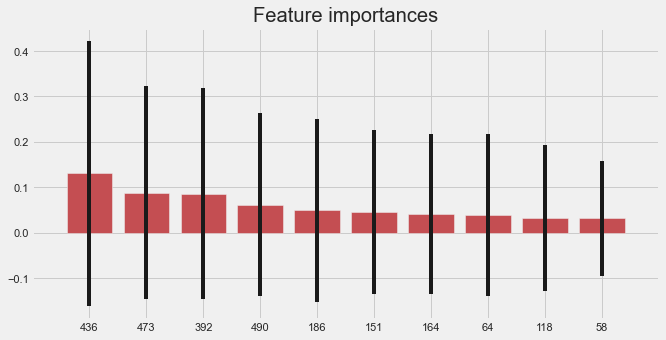

In [67]:
importances = ada_reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in ada_reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_k):
    print("%d. feature %d (%f)" % (f + 1, new_indices[f], importances[new_indices[f]]))

#Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(top_k), importances[new_indices],
       color="r", yerr=std[new_indices], align="center")

#Edited here (put top_k in range)
plt.xticks(range(top_k), new_indices)
#Edited here (put top_k)
plt.xlim([-1, top_k])
plt.show()

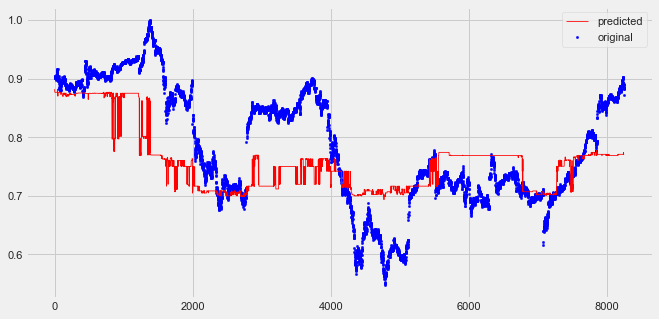

In [64]:
#visualizing the original and predicted test data in a plot
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

## Modèle de réseau de neurones

Selon les figures précedentes, nous remarquons qu'il n'ya pas une tendance déterministe sur nos série, ou des formes peudo-périodique. Ainsi en absence d'hypothèses concernant le lien entre nos données, nous estimons que S&P500 est fun fonction complexe des 500 indices. Le meilleur modèle permettant d'avoir une approximation de cette fonction, en présence de telles ambiguités sont les réseaux de neurons. <br/>

Comme la taille de l'entrée pour notre modèle restera toujours fixe, nous allons choisir d'utiliser un réseau de neurones fully connected ( chaque neurons d'une couche est connecté à tous les neurons de la couche d'avant ).<br/>

Selon des recommendations de l'état de l'art, nous utiliserons un modèle avec l'architecture suivante.<br/>

<img src = 'img/architecture.png' />

Concernant la taille du batch, le nombre de couches cachées, le nombre de neurone par couche cachée, ce sont des hyperparamètres qu'on fixe au début.
pour plus de réglage on peut utiliser la fonction (GridSearch).

La fonction de loss que nous avons utilisé est la MSE loss qui s'exprime de la façon suivante :

$MSE = \frac{1}{N}\sum{n \in [1,N]}(y_i - pred_i)^2$

In [330]:
# Déclaration des constantes importantes
batch_size    = 64
number_stocks = 500

X = tf.placeholder(dtype=tf.float32, shape=[None, number_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [331]:
# Déclaration de la taille des neurones
neuron_1 = 256
neuron_2 = 128
target = 1

In [332]:
# Initialisation des poids et des erreurs
scaler = 1
init_weight = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=scaler)
init_bias = tf.zeros_initializer()

In [333]:
# Fonction qui renvoie les poids et les erreurs
def get_neuron (dim1, dim2) :
    weight_variable =  tf.Variable(init_weight([dim1, dim2]))
    bias_variable = tf.Variable(init_bias([dim2]))
    return weight_variable, bias_variable 

In [334]:
# 1ère couche : 256 neurones
weight_1, bias_1 = get_neuron (number_stocks, neuron_1)

# 2ème couche : 128 neurones
weight_2, bias_2 = get_neuron (neuron_1, neuron_2)

# Couche output : 1 neurone
weight_output, bias_output = get_neuron (neuron_2, target)

In [335]:
# Implémentation des relations entre couches
layer_1 = tf.nn.relu(tf.add(tf.matmul(X, weight_1), bias_1))
layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weight_2), bias_2))

# Couche de sortie
layer_out = tf.transpose(tf.add(tf.matmul(layer_2, weight_output), bias_output))

# La loss function
loss = tf.reduce_mean(tf.squared_difference(layer_out, Y))

# Optimiseur
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [336]:
# Début de session d'apprentissage
sess = tf.Session()

# Initialisation des poids
sess.run(tf.global_variables_initializer())

# Nombre d'epochs 
epochs = 15

for e in range(epochs):

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        x_minibatch = X_train[start:start + batch_size]
        y_minibatch = y_train[start:start + batch_size]
        # Execution de l'optimiseur sur un batch
        sess.run(optimizer, feed_dict={X: x_minibatch, Y: y_minibatch})
        # Affichage de la progression
        if np.mod(i,5) == 0:
            print('Epoch ' + str(e) + ', Batch ' + str(i))


Epoch 0, Batch 0
Epoch 0, Batch 5
Epoch 0, Batch 10
Epoch 0, Batch 15
Epoch 0, Batch 20
Epoch 0, Batch 25
Epoch 0, Batch 30
Epoch 0, Batch 35
Epoch 0, Batch 40
Epoch 0, Batch 45
Epoch 0, Batch 50
Epoch 0, Batch 55
Epoch 0, Batch 60
Epoch 0, Batch 65
Epoch 0, Batch 70
Epoch 0, Batch 75
Epoch 0, Batch 80
Epoch 0, Batch 85
Epoch 0, Batch 90
Epoch 0, Batch 95
Epoch 0, Batch 100
Epoch 0, Batch 105
Epoch 0, Batch 110
Epoch 0, Batch 115
Epoch 0, Batch 120
Epoch 0, Batch 125
Epoch 0, Batch 130
Epoch 0, Batch 135
Epoch 0, Batch 140
Epoch 0, Batch 145
Epoch 0, Batch 150
Epoch 0, Batch 155
Epoch 0, Batch 160
Epoch 0, Batch 165
Epoch 0, Batch 170
Epoch 0, Batch 175
Epoch 0, Batch 180
Epoch 0, Batch 185
Epoch 0, Batch 190
Epoch 0, Batch 195
Epoch 0, Batch 200
Epoch 0, Batch 205
Epoch 0, Batch 210
Epoch 0, Batch 215
Epoch 0, Batch 220
Epoch 0, Batch 225
Epoch 0, Batch 230
Epoch 0, Batch 235
Epoch 0, Batch 240
Epoch 0, Batch 245
Epoch 0, Batch 250
Epoch 0, Batch 255
Epoch 0, Batch 260
Epoch 0, Batch 

Epoch 4, Batch 140
Epoch 4, Batch 145
Epoch 4, Batch 150
Epoch 4, Batch 155
Epoch 4, Batch 160
Epoch 4, Batch 165
Epoch 4, Batch 170
Epoch 4, Batch 175
Epoch 4, Batch 180
Epoch 4, Batch 185
Epoch 4, Batch 190
Epoch 4, Batch 195
Epoch 4, Batch 200
Epoch 4, Batch 205
Epoch 4, Batch 210
Epoch 4, Batch 215
Epoch 4, Batch 220
Epoch 4, Batch 225
Epoch 4, Batch 230
Epoch 4, Batch 235
Epoch 4, Batch 240
Epoch 4, Batch 245
Epoch 4, Batch 250
Epoch 4, Batch 255
Epoch 4, Batch 260
Epoch 4, Batch 265
Epoch 4, Batch 270
Epoch 4, Batch 275
Epoch 4, Batch 280
Epoch 4, Batch 285
Epoch 4, Batch 290
Epoch 4, Batch 295
Epoch 4, Batch 300
Epoch 4, Batch 305
Epoch 4, Batch 310
Epoch 4, Batch 315
Epoch 4, Batch 320
Epoch 4, Batch 325
Epoch 4, Batch 330
Epoch 4, Batch 335
Epoch 4, Batch 340
Epoch 4, Batch 345
Epoch 4, Batch 350
Epoch 4, Batch 355
Epoch 4, Batch 360
Epoch 4, Batch 365
Epoch 4, Batch 370
Epoch 4, Batch 375
Epoch 4, Batch 380
Epoch 4, Batch 385
Epoch 4, Batch 390
Epoch 4, Batch 395
Epoch 4, Bat

Epoch 8, Batch 260
Epoch 8, Batch 265
Epoch 8, Batch 270
Epoch 8, Batch 275
Epoch 8, Batch 280
Epoch 8, Batch 285
Epoch 8, Batch 290
Epoch 8, Batch 295
Epoch 8, Batch 300
Epoch 8, Batch 305
Epoch 8, Batch 310
Epoch 8, Batch 315
Epoch 8, Batch 320
Epoch 8, Batch 325
Epoch 8, Batch 330
Epoch 8, Batch 335
Epoch 8, Batch 340
Epoch 8, Batch 345
Epoch 8, Batch 350
Epoch 8, Batch 355
Epoch 8, Batch 360
Epoch 8, Batch 365
Epoch 8, Batch 370
Epoch 8, Batch 375
Epoch 8, Batch 380
Epoch 8, Batch 385
Epoch 8, Batch 390
Epoch 8, Batch 395
Epoch 8, Batch 400
Epoch 8, Batch 405
Epoch 8, Batch 410
Epoch 8, Batch 415
Epoch 8, Batch 420
Epoch 8, Batch 425
Epoch 8, Batch 430
Epoch 8, Batch 435
Epoch 8, Batch 440
Epoch 8, Batch 445
Epoch 8, Batch 450
Epoch 8, Batch 455
Epoch 8, Batch 460
Epoch 8, Batch 465
Epoch 8, Batch 470
Epoch 8, Batch 475
Epoch 8, Batch 480
Epoch 8, Batch 485
Epoch 8, Batch 490
Epoch 8, Batch 495
Epoch 8, Batch 500
Epoch 8, Batch 505
Epoch 8, Batch 510
Epoch 9, Batch 0
Epoch 9, Batch

Epoch 12, Batch 440
Epoch 12, Batch 445
Epoch 12, Batch 450
Epoch 12, Batch 455
Epoch 12, Batch 460
Epoch 12, Batch 465
Epoch 12, Batch 470
Epoch 12, Batch 475
Epoch 12, Batch 480
Epoch 12, Batch 485
Epoch 12, Batch 490
Epoch 12, Batch 495
Epoch 12, Batch 500
Epoch 12, Batch 505
Epoch 12, Batch 510
Epoch 13, Batch 0
Epoch 13, Batch 5
Epoch 13, Batch 10
Epoch 13, Batch 15
Epoch 13, Batch 20
Epoch 13, Batch 25
Epoch 13, Batch 30
Epoch 13, Batch 35
Epoch 13, Batch 40
Epoch 13, Batch 45
Epoch 13, Batch 50
Epoch 13, Batch 55
Epoch 13, Batch 60
Epoch 13, Batch 65
Epoch 13, Batch 70
Epoch 13, Batch 75
Epoch 13, Batch 80
Epoch 13, Batch 85
Epoch 13, Batch 90
Epoch 13, Batch 95
Epoch 13, Batch 100
Epoch 13, Batch 105
Epoch 13, Batch 110
Epoch 13, Batch 115
Epoch 13, Batch 120
Epoch 13, Batch 125
Epoch 13, Batch 130
Epoch 13, Batch 135
Epoch 13, Batch 140
Epoch 13, Batch 145
Epoch 13, Batch 150
Epoch 13, Batch 155
Epoch 13, Batch 160
Epoch 13, Batch 165
Epoch 13, Batch 170
Epoch 13, Batch 175
Ep

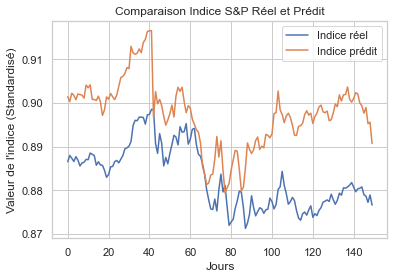

L'erreur MSE est égale à : 0.003711071563884616
L'erreur RMSE est égale à : 0.06091856583952904


In [337]:
prediction = sess.run(layer_out, feed_dict={X: X_test})

#Plot des performances 
plt.clf()
plt.plot(range(150), prediction[0][:150])
plt.plot(range(150), y_test[:150])
plt.title('Comparaison Indice S&P Réel et Prédit')
plt.xlabel('Jours')
plt.ylabel("Valeur de l'indice (Standardisé)")
plt.legend(["Indice réel","Indice prédit"])
plt.show()

# L'erreur finale
final_mse = sess.run(loss, feed_dict={X: X_test, Y: y_test})
print("L'erreur MSE est égale à : {}".format(final_mse))

final_rmse = np.sqrt(final_mse)
print("L'erreur RMSE est égale à : {}".format(final_rmse))


# STILL TO CHECK

## Prévision avec régression linéaire 

Dans cette partie nous supposerons l'existence d'une relation linéaire entre nos données ( Hypothèse que l'on cherchera à valider par la suite ) et nous essayerons de mettre en place un modèle de régression linéaire.

Ainsi dans un premier temps nous essayerons de faire une regression en fonction de tout les 500 features, en utilisant les données standardisés et la même subdivision pour le set, entrainement - test

La MSE pour le modèle est : 0.0003086998683112385
Le coefficient R2 est égale à : 0.9690024727137819


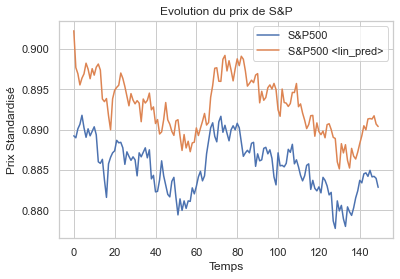

In [117]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Le modèle de regression linéaire 
reg             = LinearRegression().fit(X_train, y_train)
pred            = reg.predict(X_test)

mse_regression  = 0 

for i in range(len(y_test)):
    mse_regression += ((y_test[i] - pred[i])**2)

mse_regression = mse_regression/len(y_test)
r2             = reg.score(X_test, y_test)

print("La MSE pour le modèle est : {}".format(mse_regression))
print("Le coefficient R2 est égale à : {}".format(r2))

# Plot comparatif entre modèle réel et estimé
plt.clf()
plt.plot(range(150), y_test[150:300])
plt.plot(range(150), pred[150:300]  )
plt.title("Evolution du prix de S&P")
plt.xlabel("Temps")
plt.ylabel("Prix Standardisé")
plt.legend(["S&P500", "S&P500 <lin_pred>"])
plt.show()


Ce modèle est très performant, et donne une erreur de 6.91329941919845e-06, Ce qui nous pousse à considérer l'existence d'une relation linéaire entre toutes ces variables. Le coefficient R2 ici est proche de 1, ce qui signifie que le modèle explique bien la variance des données.

Nous regardons les coefficients de regression qui ont été utilisé : 

In [204]:
print("L'intercept est : {}".format(reg.intercept_))
print("Les poids associées aux variables (Dans l'ordre) sont : {}".format(reg.coef_))

L'intercept est : -0.7088340455673819
Les poids associées aux variables (Dans l'ordre) sont : [ 4.55637718e-03  8.92175523e-02  8.00567064e-03  3.86160715e-03
  1.20571799e-02  7.77841306e-03  5.14699114e-03  3.84916785e-03
  7.04566042e-03  1.52087021e-03  1.23316348e-02  5.85904392e-02
  6.63866444e-03  1.62429750e-02  1.48616195e-03  7.99658116e-03
 -8.55133254e-04  7.33966070e-03  1.40809976e-02  3.72268281e-03
  4.48612738e-03  7.88168504e-03 -8.27518709e-04  1.81037647e-02
 -5.41679488e-04  6.17610006e-03  1.46723798e-02  5.39248843e-03
 -4.69875460e-04  9.81259744e-03  3.77920077e-04  3.23244844e-03
  1.60188372e-03  2.76876620e-03  2.33853938e-03  7.11756678e-03
  4.51868175e-03  7.40562343e-04  6.96496761e-03  5.96695485e-04
  2.29852235e-03  2.45123558e-03  6.78127538e-03  6.63614375e-02
  2.99307483e-04  2.77686815e-03  5.26585663e-03  5.21693652e-04
 -6.22340516e-03  1.49455157e-02  1.66376905e-02  3.21630552e-02
  3.49414578e-02 -9.80822156e-04 -7.23945560e-04  4.53500716e

## Validation hypothèse linéarité (Normalité des résidus)

Nous nous intéressons cette fois-ci au plot des résidus, si notre hypothèse est valable
les résidus doivent avoit une allure gaussienne

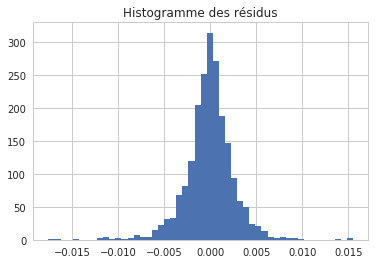

La skewness de la série est : -0.4215548463365436
Le curtosis de la série est : 5.120043768341926


In [205]:
from scipy.stats import kurtosis
from scipy.stats import skew


res = [(y_test[i] - pred[i]) for i in range(len(y_test))]

# Plot de l'histogramme des résidus
plt.clf()
plt.hist(res, bins=50)
plt.title("Histogramme des résidus")
plt.show()


print("La skewness de la série est : {}".format(skew(res)))
print("Le curtosis de la série est : {}".format(kurtosis(res)))



Ainsi comme nous nous attendions, les résidus suivent un profil gaussien , confirmé aussi par
les valeurs des skewness et curtosis. qui s'interprètent comme suit : 

<img src = "img/skw.gif" />

## Prévision avec arbre de regression

Nous implémentons pour ce dernier cas un arbre de regression. Dans ces structures d'arbre, les feuilles représentent les valeurs de la variable-cible et les embranchements correspondent à des combinaisons de variables d'entrée qui mènent à ces valeurs.
En analyse de décision, un arbre de décision peut être utilisé pour représenter de manière explicite les décisions réalisées et les processus qui les amènent.<br/><br/>
Dans notre cas nous ne pouvons pas visualiser cela puisque la taille de l'arbre sera assez grande. Nous nous contentons que de la mesure de performance finale <br/>



La MSE pour le modèle est : 3.3494667728674657e-09


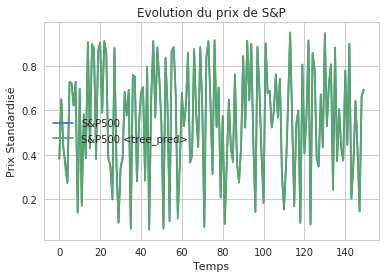

In [154]:
from sklearn.tree import DecisionTreeRegressor

reg_tree        = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

pred_tree       = reg_tree.predict(X_test)

mse_tree        = 0 

for i in range(len(y_test)):
    mse_tree   += ((y_test[i] - pred[i])**2)

mse_regression  = mse_regression/len(y_test)

print("La MSE pour le modèle est : {}".format(mse_regression))

# Plot comparatif entre modèle réel et estimé
plt.clf()
plt.plot(range(150), y_test[150:300])
plt.plot(range(150), pred_tree[150:300]  )
plt.title("Evolution du prix de S&P")
plt.xlabel("Temps")
plt.ylabel("Prix Standardisé")
plt.legend(["S&P500", "S&P500 <tree_pred>"])
plt.show()

Comme nous voyons, le modèle "Regression tree" est le plus performant parmis tous les autres.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg_tree        = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

pred_tree       = reg_tree.predict(X_test)

mse_tree        = 0 

for i in range(len(y_test)):
    mse_tree   += ((y_test[i] - pred[i])**2)

mse_regression  = mse_regression/len(y_test)

print("La MSE pour le modèle est : {}".format(mse_regression))

# Plot comparatif entre modèle réel et estimé
plt.clf()
plt.plot(range(150), y_test[150:300])
plt.plot(range(150), pred_tree[150:300]  )
plt.title("Evolution du prix de S&P")
plt.xlabel("Temps")
plt.ylabel("Prix Standardisé")
plt.legend(["S&P500", "S&P500 <tree_pred>"])
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.05, random_state=1)
print("La taille du dataset utilisé pour l'entrainement : {}".format(len(y_train)))
print("La taille du dataset utilisé pour le test : {}".format(len(y_test)))
y_train = y_train.flatten()
y_test  = y_test.flatten()